In [1]:
using ITensors
using Distributions
using HDF5
using Random
using Plots
using Plots.PlotMeasures
using MLDataUtils, StatsBase
using DelimitedFiles
include("../SweepOptRegular.jl")

InspectOverlap (generic function with 2 methods)

In [2]:
ecg_dat = readdlm("../ECG200_TRAIN.txt")
X_train = ecg_dat[:, 2:end]
y_train = Int.(ecg_dat[:, 1])
remap = Dict(-1 => 0, 1 => 1)
y_train = [remap[label] for label in y_train];
y_train = reshape(y_train, length(y_train), 1);

In [3]:
ecg_dat_test = readdlm("../ECG200_TEST.txt")
X_test = ecg_dat_test[:, 2:end]
y_test = Int.(ecg_dat_test[:, 1])
y_test = [remap[label] for label in y_test]
y_test = reshape(y_test, length(y_test), 1);

In [4]:
struct RobustSigmoidTransform{T<:Real} <: AbstractDataTransform
    median::T
    iqr::T
    k::T
    positive::Bool

    function RobustSigmoidTransform(median::T, iqr::T, k::T, positive=true) where T<:Real
        new{T}(median, iqr, k, positive)
    end
end

function robust_sigmoid(x::Real, median::Real, iqr::Real, k::Real, positive::Bool)
    xhat = 1.0 / (1.0 + exp(-(x - median) / (iqr / k)))
    if !positive
        xhat = 2*xhat - 1
    end
    return xhat
end

function fitScaler(::Type{RobustSigmoidTransform}, X::Matrix; k::Real=1.35, positive::Bool=true)
    medianX = median(X)
    iqrX = iqr(X)
    return RobustSigmoidTransform(medianX, iqrX, k, positive)
end

function transformData(t::RobustSigmoidTransform, X::Matrix)
    return map(x -> robust_sigmoid(x, t.median, t.iqr, t.k, t.positive), X)
end

# New SigmoidTransform
struct SigmoidTransform <: AbstractDataTransform
    positive::Bool
end

function sigmoid(x::Real, positive::Bool)
    xhat = 1.0 / (1.0 + exp(-x))
    if !positive
        xhat = 2*xhat - 1
    end
    return xhat
end

function fitScaler(::Type{SigmoidTransform}, X::Matrix; positive::Bool=true)
    return SigmoidTransform(positive)
end

function transformData(t::SigmoidTransform, X::Matrix)
    return map(x -> sigmoid(x, t.positive), X)
end;

In [5]:
rst = fitScaler(RobustSigmoidTransform, X_train; positive=true)
X_train_normalised = transformData(rst, X_train)
X_test_normalised = transformData(rst, X_test);

In [6]:
W, sites = fitMPS(X_train_normalised, y_train; χ_max=15, nsweep=10, α=0.01, χ_init=2, random_state=42)

Initialising training states.


Parameters: 
Feature map: AngleEncoder
Initial bond dimension χ_init: 2
Step size α: 0.01
Maximum number of sweeps: 10
Maximum bond dimension χ_max: 15
Generating initial weight MPS with bond dimension χ = 2 using random seed 42.


Forward Sweep L -> R (1/10)


Backward Sweep R -> L (1/10)


Training loss after Sweep 1: 0.4729714659674066 | Training Acc: 0.83
ΔC train after sweep 1: 0.02702853403259342
Forward Sweep L -> R (2/10)


Backward Sweep R -> L (2/10)


Training loss after Sweep 2: 0.38548779938656397 | Training Acc: 0.85
ΔC train after sweep 2: 0.08748366658084261
Forward Sweep L -> R (3/10)


Backward Sweep R -> L (3/10)


Training loss after Sweep 3: 0.34318260070393086 | Training Acc: 0.92
ΔC train after sweep 3: 0.042305198682633105
Forward Sweep L -> R (4/10)


Backward Sweep R -> L (4/10)


Training loss after Sweep 4: 0.33714172067285075 | Training Acc: 0.94
ΔC train after sweep 4: 0.006040880031080109
Forward Sweep L -> R (5/10)


Backward Sweep R -> L (5/10)


Training loss after Sweep 5: 0.334368758216246 | Training Acc: 0.96
ΔC train after sweep 5: 0.002772962456604744
Forward Sweep L -> R (6/10)


Backward Sweep R -> L (6/10)


Training loss after Sweep 6: 0.33281204884197757 | Training Acc: 0.97
ΔC train after sweep 6: 0.001556709374268439
Forward Sweep L -> R (7/10)


Backward Sweep R -> L (7/10)


Training loss after Sweep 7: 0.33155697953043095 | Training Acc: 0.98
ΔC train after sweep 7: 0.0012550693115466194
Forward Sweep L -> R (8/10)


Backward Sweep R -> L (8/10)


Training loss after Sweep 8: 0.33056513936549586 | Training Acc: 0.98
ΔC train after sweep 8: 0.0009918401649350872
Forward Sweep L -> R (9/10)


Backward Sweep R -> L (9/10)


Training loss after Sweep 9: 0.329795395168057 | Training Acc: 0.98
ΔC train after sweep 9: 0.0007697441974388597
Forward Sweep L -> R (10/10)


Backward Sweep R -> L (10/10)


Training loss after Sweep 10: 0.32917150787844096 | Training Acc: 0.98
ΔC train after sweep 10: 0.000623887289616043


(MPS
[1] ((dim=2|id=97|"S=1/2,Site,n=1"), (dim=2|id=121|"decision"), (dim=4|id=628|"Link,l=1"))
[2] ((dim=2|id=622|"S=1/2,Site,n=2"), (dim=8|id=706|"Link,l=2"), (dim=4|id=628|"Link,l=1"))
[3] ((dim=2|id=223|"S=1/2,Site,n=3"), (dim=15|id=447|"Link,l=3"), (dim=8|id=706|"Link,l=2"))
[4] ((dim=2|id=302|"S=1/2,Site,n=4"), (dim=15|id=698|"Link,l=4"), (dim=15|id=447|"Link,l=3"))
[5] ((dim=2|id=368|"S=1/2,Site,n=5"), (dim=15|id=614|"Link,l=5"), (dim=15|id=698|"Link,l=4"))
[6] ((dim=2|id=179|"S=1/2,Site,n=6"), (dim=15|id=319|"Link,l=6"), (dim=15|id=614|"Link,l=5"))
[7] ((dim=2|id=105|"S=1/2,Site,n=7"), (dim=15|id=938|"Link,l=7"), (dim=15|id=319|"Link,l=6"))
[8] ((dim=2|id=339|"S=1/2,Site,n=8"), (dim=15|id=706|"Link,l=8"), (dim=15|id=938|"Link,l=7"))
[9] ((dim=2|id=145|"S=1/2,Site,n=9"), (dim=15|id=394|"Link,l=9"), (dim=15|id=706|"Link,l=8"))
[10] ((dim=2|id=515|"S=1/2,Site,n=10"), (dim=15|id=604|"Link,l=10"), (dim=15|id=394|"Link,l=9"))
[11] ((dim=2|id=859|"S=1/2,Site,n=11"), (dim=15|id=994|"Li

In [7]:
ScoreMPS(W, X_test_normalised, y_test)

Initialising testing states.


Test loss: 0.35350684314830777 | Test Accuracy: 0.92


2-element Vector{Float64}:
 0.35350684314830777
 0.92

In [8]:
mps_state_0 = deepcopy(W);
println(norm(mps_state_0))
decision_idx = findindex(mps_state_0[1], "decision")
decision_state_0 = onehot(decision_idx => (1))
mps_state_0[1] *= decision_state_0
normalize!(mps_state_0)

0.9999999999999976


MPS
[1] ((dim=2|id=97|"S=1/2,Site,n=1"), (dim=4|id=628|"Link,l=1"))
[2] ((dim=2|id=622|"S=1/2,Site,n=2"), (dim=8|id=706|"Link,l=2"), (dim=4|id=628|"Link,l=1"))
[3] ((dim=2|id=223|"S=1/2,Site,n=3"), (dim=15|id=447|"Link,l=3"), (dim=8|id=706|"Link,l=2"))
[4] ((dim=2|id=302|"S=1/2,Site,n=4"), (dim=15|id=698|"Link,l=4"), (dim=15|id=447|"Link,l=3"))
[5] ((dim=2|id=368|"S=1/2,Site,n=5"), (dim=15|id=614|"Link,l=5"), (dim=15|id=698|"Link,l=4"))
[6] ((dim=2|id=179|"S=1/2,Site,n=6"), (dim=15|id=319|"Link,l=6"), (dim=15|id=614|"Link,l=5"))
[7] ((dim=2|id=105|"S=1/2,Site,n=7"), (dim=15|id=938|"Link,l=7"), (dim=15|id=319|"Link,l=6"))
[8] ((dim=2|id=339|"S=1/2,Site,n=8"), (dim=15|id=706|"Link,l=8"), (dim=15|id=938|"Link,l=7"))
[9] ((dim=2|id=145|"S=1/2,Site,n=9"), (dim=15|id=394|"Link,l=9"), (dim=15|id=706|"Link,l=8"))
[10] ((dim=2|id=515|"S=1/2,Site,n=10"), (dim=15|id=604|"Link,l=10"), (dim=15|id=394|"Link,l=9"))
[11] ((dim=2|id=859|"S=1/2,Site,n=11"), (dim=15|id=994|"Link,l=11"), (dim=15|id=604|"L

In [9]:
mps_state_1 = deepcopy(W);
println(norm(mps_state_1))
decision_idx = findindex(mps_state_1[1], "decision")
decision_state_1 = onehot(decision_idx => (2))
mps_state_1[1] *= decision_state_1
normalize!(mps_state_1)

0.9999999999999976


MPS
[1] ((dim=2|id=97|"S=1/2,Site,n=1"), (dim=4|id=628|"Link,l=1"))
[2] ((dim=2|id=622|"S=1/2,Site,n=2"), (dim=8|id=706|"Link,l=2"), (dim=4|id=628|"Link,l=1"))
[3] ((dim=2|id=223|"S=1/2,Site,n=3"), (dim=15|id=447|"Link,l=3"), (dim=8|id=706|"Link,l=2"))
[4] ((dim=2|id=302|"S=1/2,Site,n=4"), (dim=15|id=698|"Link,l=4"), (dim=15|id=447|"Link,l=3"))
[5] ((dim=2|id=368|"S=1/2,Site,n=5"), (dim=15|id=614|"Link,l=5"), (dim=15|id=698|"Link,l=4"))
[6] ((dim=2|id=179|"S=1/2,Site,n=6"), (dim=15|id=319|"Link,l=6"), (dim=15|id=614|"Link,l=5"))
[7] ((dim=2|id=105|"S=1/2,Site,n=7"), (dim=15|id=938|"Link,l=7"), (dim=15|id=319|"Link,l=6"))
[8] ((dim=2|id=339|"S=1/2,Site,n=8"), (dim=15|id=706|"Link,l=8"), (dim=15|id=938|"Link,l=7"))
[9] ((dim=2|id=145|"S=1/2,Site,n=9"), (dim=15|id=394|"Link,l=9"), (dim=15|id=706|"Link,l=8"))
[10] ((dim=2|id=515|"S=1/2,Site,n=10"), (dim=15|id=604|"Link,l=10"), (dim=15|id=394|"Link,l=9"))
[11] ((dim=2|id=859|"S=1/2,Site,n=11"), (dim=15|id=994|"Link,l=11"), (dim=15|id=604|"L

In [10]:
function entropy_von_neumann(ψ::MPS, b::Int)
    psi = deepcopy(ψ)
    s = siteinds(psi)
    orthogonalize!(psi, b) # change orthogonality center to site B
    #print(norm(psi))
    if b == 1
        _, S = svd(psi[b], (siteind(psi, b),))
    else
        _, S = svd(psi[b], (linkind(psi, b-1), s[b]))
    end
    SvN = 0.0
    for n in 1:ITensors.dim(S, 1)
        p = S[n, n]^2
        if p > 1E-12
            SvN -= p * log(p)
        end
    end

    return SvN
end;

In [11]:
S_before = [entropy_von_neumann(mps_state_1, site_idx) for site_idx in 1:length(mps_state_1)]

96-element Vector{Float64}:
 0.12160278221523235
 0.2459578856482383
 0.38008487581194306
 0.5312882093843305
 0.7017957143655493
 0.8612115644837147
 0.9580988241479618
 1.01884746666543
 1.0804760266772662
 1.121295144869987
 ⋮
 0.8831292548066648
 0.8265842427022317
 0.8062580053398477
 0.7724153607626044
 0.6501509886330211
 0.504777334626947
 0.32380502930243593
 0.14598150246736966
 1.2212453270876646e-14

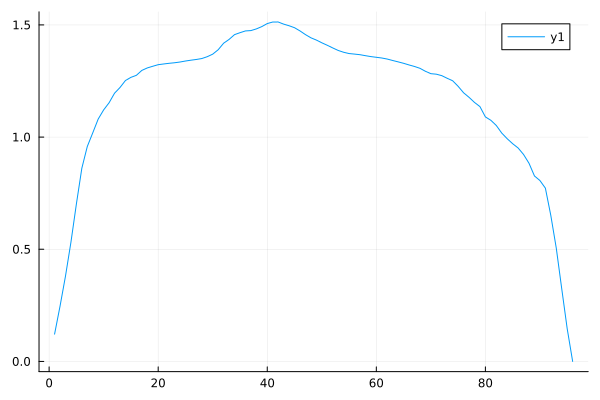

In [12]:
plot(S_before)

# Class 0 sample

In [13]:
function GenerateSingleProductState(normalised_sample::Vector, site_inds)

    """Convert a single normalised sample to a product state with local dimension defined by the feature map."""

    N_sites = size(normalised_sample)[1]
    feature_map = AngleEncoder
    d = 2

    product_state = MPS(site_inds; linkdims=1)

    if N_sites !== size(normalised_sample)[1]
        error("Number of MPS sites (N = $N_sites) does not match the length of the time-series sample (N = $(size(normalised_sample)[1])).")
    end

    for j=1:N_sites
        T = ITensor(site_inds[j])
        mapped_vals = feature_map(normalised_sample[j])
        if length(mapped_vals) == d
            if length(mapped_vals) == 2
                up_val, down_val = mapped_vals
                T[1] = up_val
                T[2] = down_val
            elseif length(mapped_vals) == 3
                up_val, zero_val, down_val = mapped_vals
                T[1] = down_val
                T[2] = zero_val
                T[3] = up_val
            else
                error("Feature map output dimension incorrect.")
            end
        else
            error("Feature map dimension does match site indices dimension.")
        end
        product_state[j] = T
    end
    return product_state
end;

In [14]:
class_0_idxs = findall(x -> x.== 0, y_train[:,1])
class_1_idxs = findall(x -> x.== 1, y_train[:,1]);

class_0_samples = X_train_normalised[class_0_idxs, :]
class_1_samples = X_train_normalised[class_1_idxs, :];

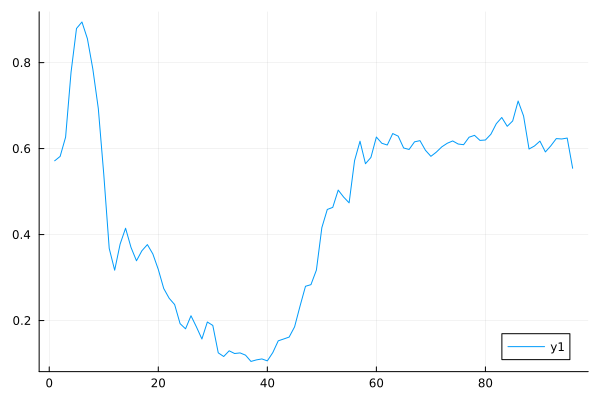

In [15]:
plot(class_0_samples[1, :])

In [16]:
function ComputeAverageVariation(sample_idx::Int, site_idx::Int, initial_state::MPS)
    ψ = deepcopy(initial_state)
    sites = siteinds(ψ)
    # get the EE of the MPS for all sites but the site to be measured
    sample = X_train_normalised[sample_idx, :]
    ϕ = GenerateSingleProductState(sample, sites)
    S_before = [entropy_von_neumann(ψ, site) for site=1:length(ψ) if site != site_idx]
    # get projector
    projector = Vector(ϕ[site_idx]) * Vector(ϕ[site_idx])'
    projector_op = op(projector, sites[site_idx])
    new_site = projector_op * ψ[site_idx]
    noprime!(new_site)
    ψ[site_idx] = new_site
    normalize!(ψ)
    S_after = [entropy_von_neumann(ψ, site) for site=1:length(ψ) if site != site_idx]
    δs = S_after .- S_before
    sum_δs = sum(δs)
    average_δs = sum_δs / (length(ψ) - 1)
    return average_δs
end


ComputeAverageVariation (generic function with 1 method)

In [18]:
sample_1_average_δs = [ComputeAverageVariation(1, site, mps_state_0) for site=1:96]

96-element Vector{Float64}:
 -0.0008168552595026153
 -0.007621559576800467
 -0.022243120759588446
 -0.04809296865847427
 -0.07824520152224244
 -0.08050658074268785
 -0.06701774951268681
 -0.056074230833679475
 -0.031180741189137044
 -0.014645129634631542
  ⋮
 -0.012205625702866651
 -0.008567222916557246
 -0.01324263470515688
 -0.02331249352993063
 -0.030660796116078484
 -0.028171352872633563
 -0.023548952966628327
 -0.03581346846267685
 -0.017306535058956792

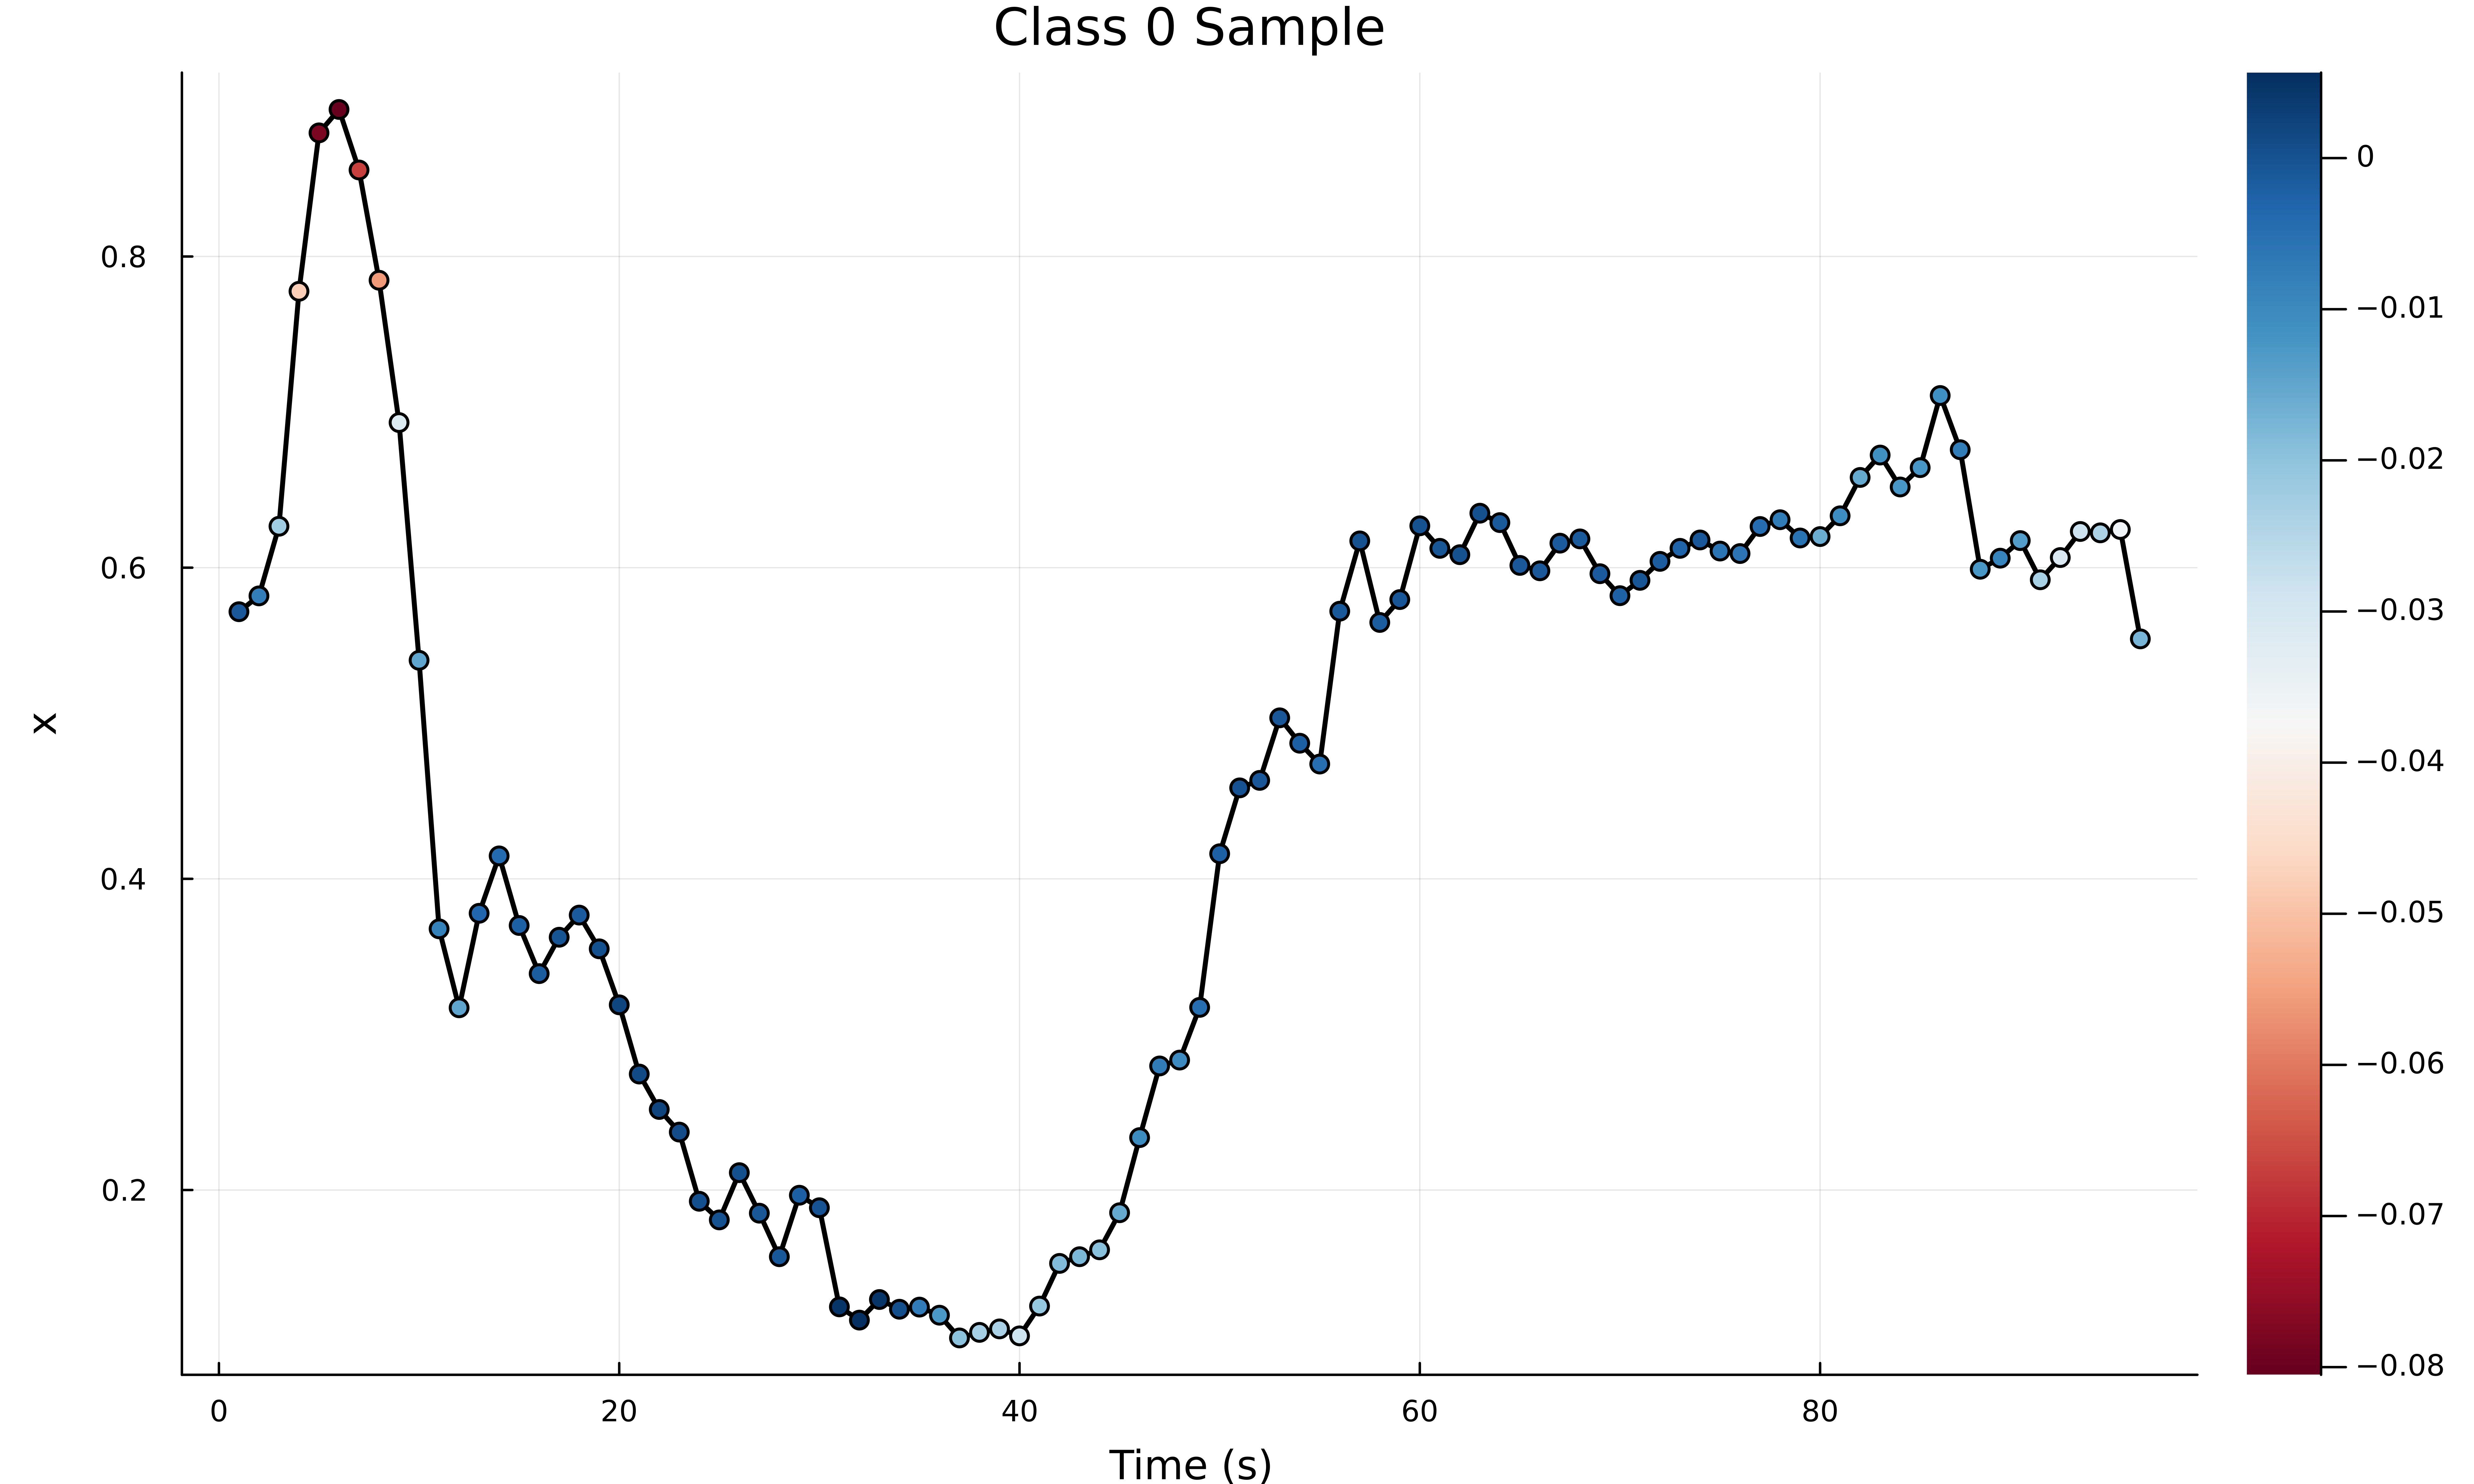

In [19]:
plot(X_train_normalised[1, :], linewidth=2, label="", dpi=800, color=:black)
scatter!(X_train_normalised[1, :], marker_z=sample_1_average_δs, size=(1000, 600), colormap=:RdBu, ms=4, left_margin=5mm, label="")
title!("Class 0 Sample")
xlabel!("Time (s)")
ylabel!("x")
#savefig("figs_attempt2/class_0_sample_id_1.png")

In [23]:
sample_1_average_δs_state_1 = [ComputeAverageVariation(1, site, mps_state_1) for site=1:96]

96-element Vector{Float64}:
 -0.013846852705579112
 -0.01548820597432435
 -0.01334406235176683
 -0.02600210623706735
 -0.02064899374320584
 -0.0010148618634621268
  0.016861614360989964
 -0.005572518066185189
 -0.033162076455722056
 -0.024696352992698675
  ⋮
 -0.006717907644189769
 -0.010502383425617677
 -0.009181105884009642
 -0.017015206597676018
 -0.027419027210508515
 -0.024265746702616657
 -0.012221159307541281
 -0.02980025569660513
 -0.016735421234708645

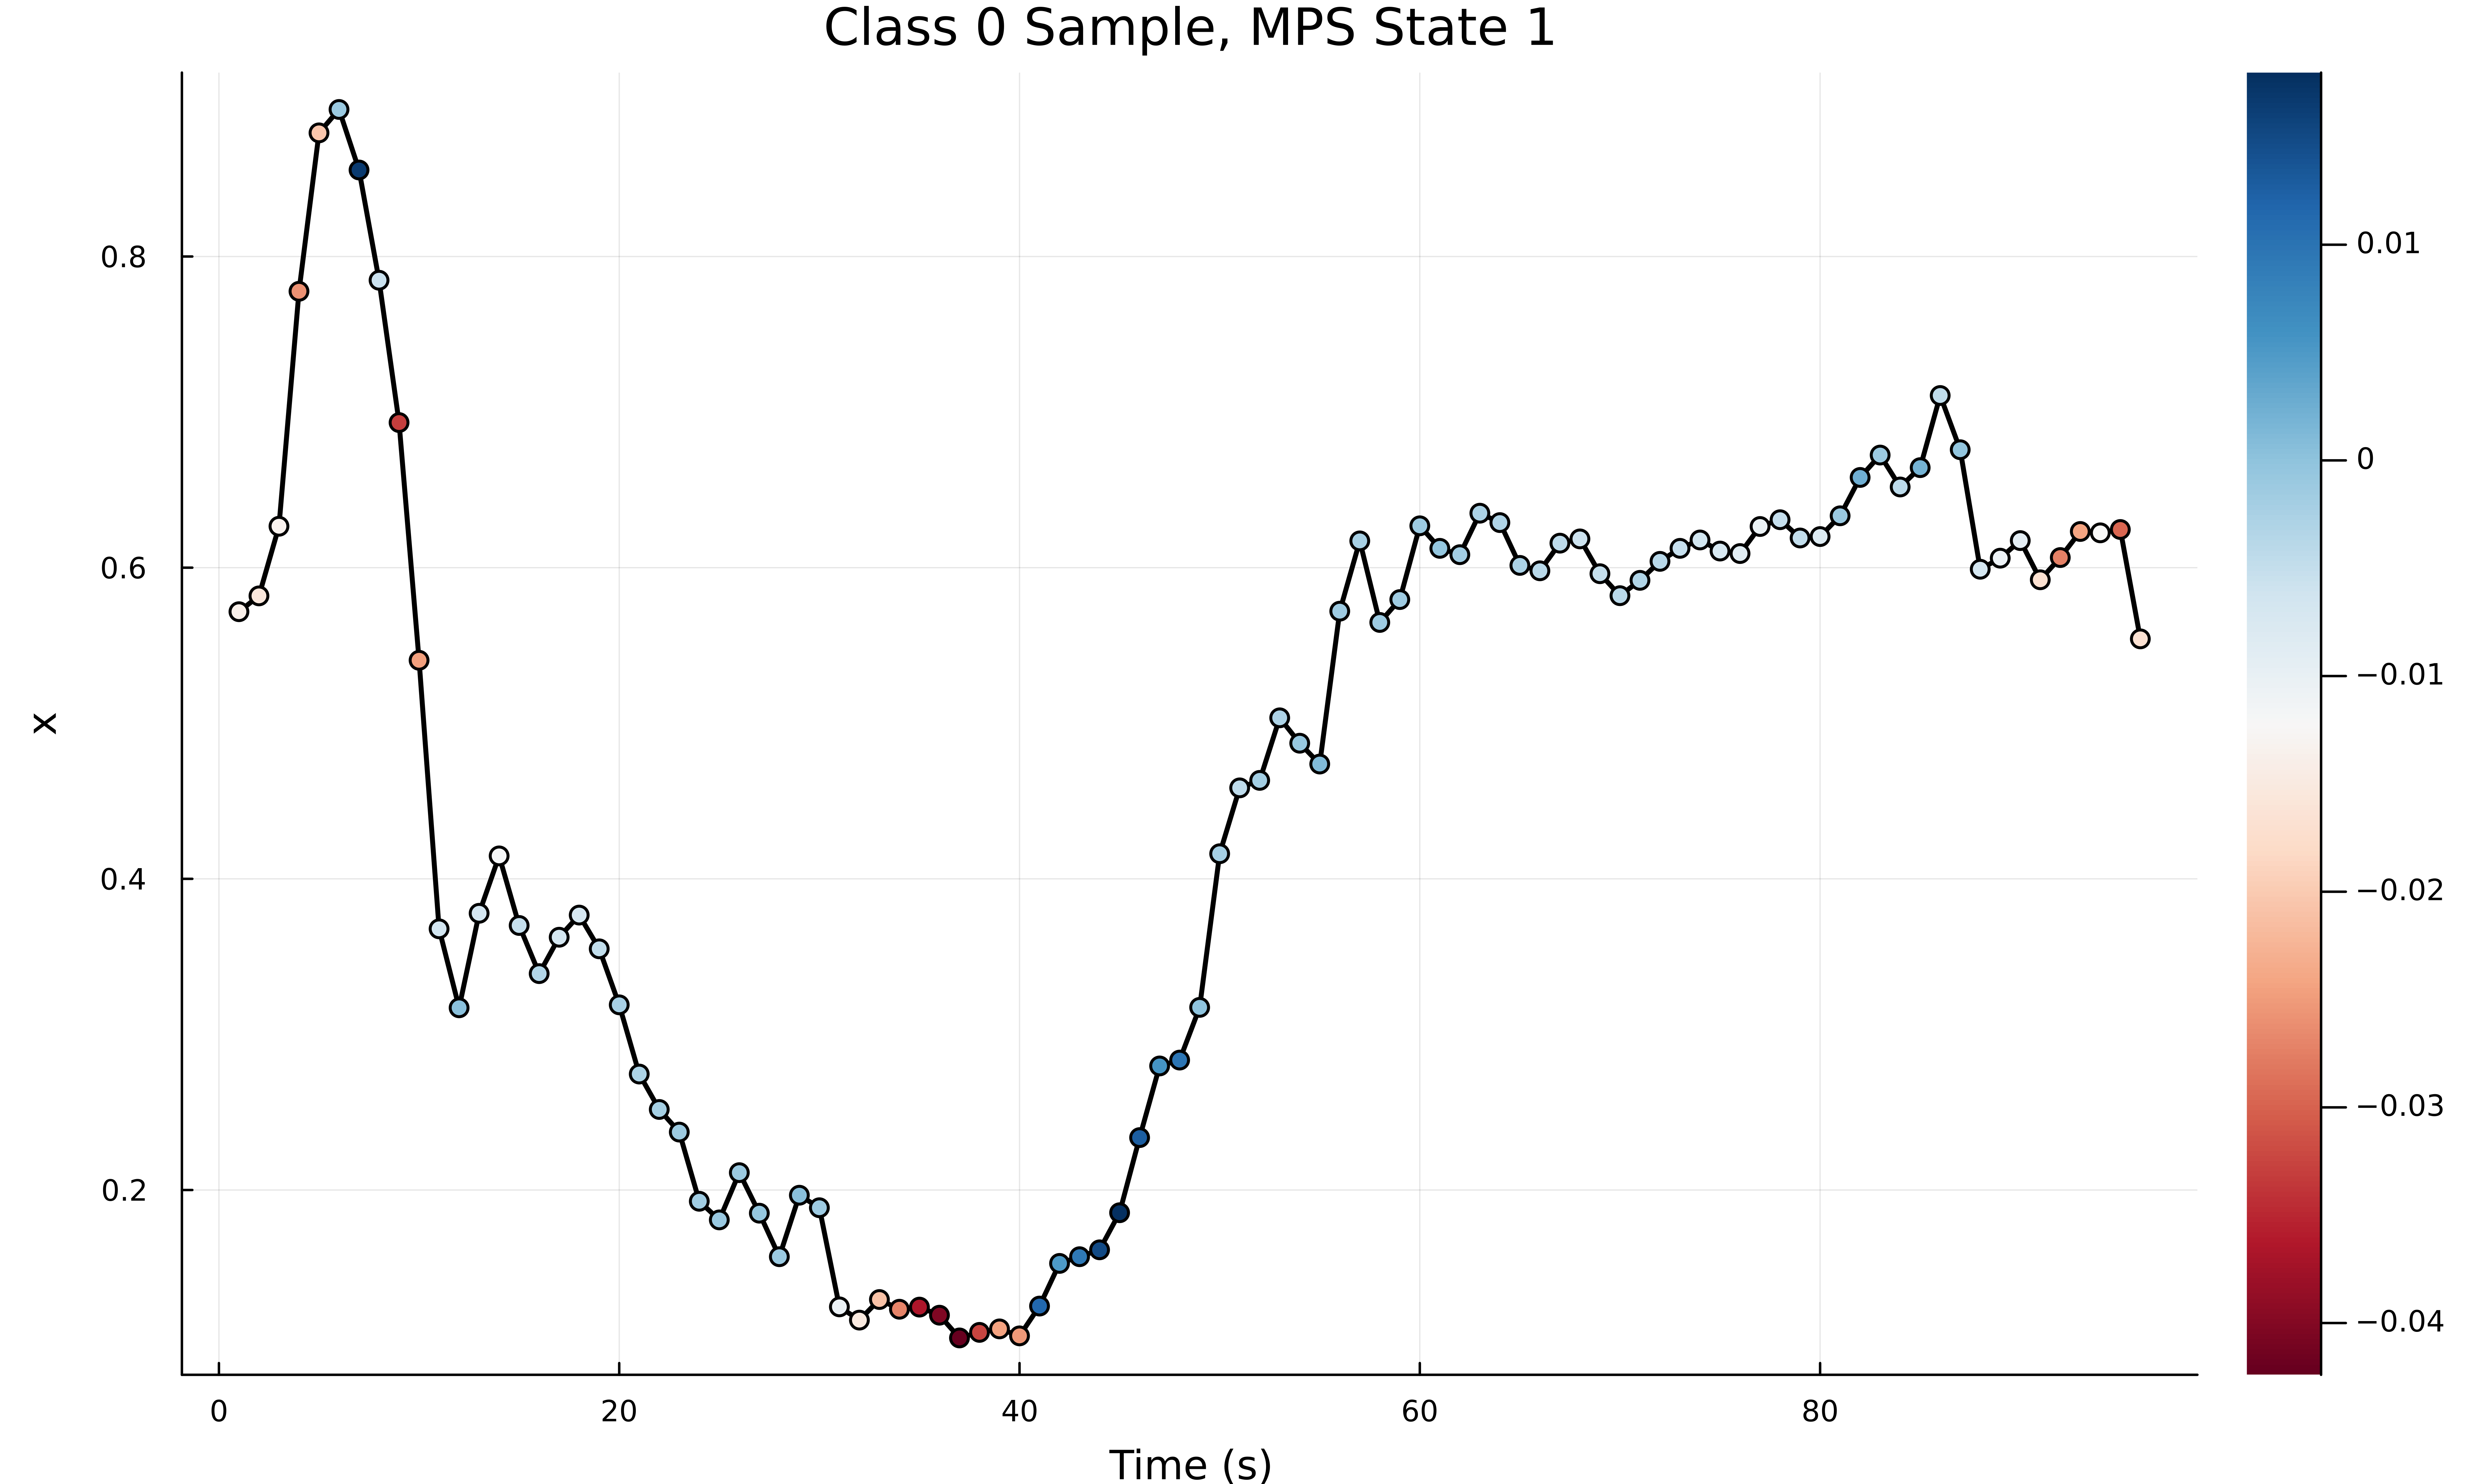

In [27]:
plot(X_train_normalised[1, :], linewidth=2, label="", dpi=800, color=:black)
scatter!(X_train_normalised[1, :], marker_z=sample_1_average_δs_state_1, size=(1000, 600), colormap=:RdBu, ms=4, left_margin=5mm, label="")
title!("Class 0 Sample, MPS State 1")
xlabel!("Time (s)")
ylabel!("x")
#savefig("figs_attempt2/class_0_sample_id_1_state1.png")

Try computing the average EE variation for 5 class 0 samples

In [32]:
per_sample_average_δs = []
for i=1:5
    println("Computing EE for sample $i")
    sample_average_δs = [ComputeAverageVariation(class_0_idxs[i], site, mps_state_0) for site=1:96]
    push!(per_sample_average_δs, sample_average_δs)
end

Computing EE for sample 1


Computing EE for sample 2


Computing EE for sample 3


Computing EE for sample 4


Computing EE for sample 5


In [33]:
per_sample_average_δs

5-element Vector{Any}:
 [-0.0008168552595026153, -0.007621559576800467, -0.022243120759588446, -0.04809296865847427, -0.07824520152224244, -0.08050658074268785, -0.06701774951268681, -0.056074230833679475, -0.031180741189137044, -0.014645129634631542  …  -0.007370819081451425, -0.012205625702866651, -0.008567222916557246, -0.01324263470515688, -0.02331249352993063, -0.030660796116078484, -0.028171352872633563, -0.023548952966628327, -0.03581346846267685, -0.017306535058956792]
 [0.00556641362642977, 0.003005262520319941, -0.012580296772726159, -0.03666327907521204, -0.0654044239928268, -0.0660864520197035, -0.06023830042455572, -0.06103667071651602, -0.035848961611024445, -0.015946975001724418  …  -0.006928810524578561, -0.012208727739326809, -0.009343803326840223, -0.014669586033194583, -0.023146817497856485, -0.029041972312509424, -0.026283676621835804, -0.023589240890406368, -0.038635933733460144, -0.0204883149833986]
 [-0.022352718227448682, -0.05947289876996868, -0.051987219960407

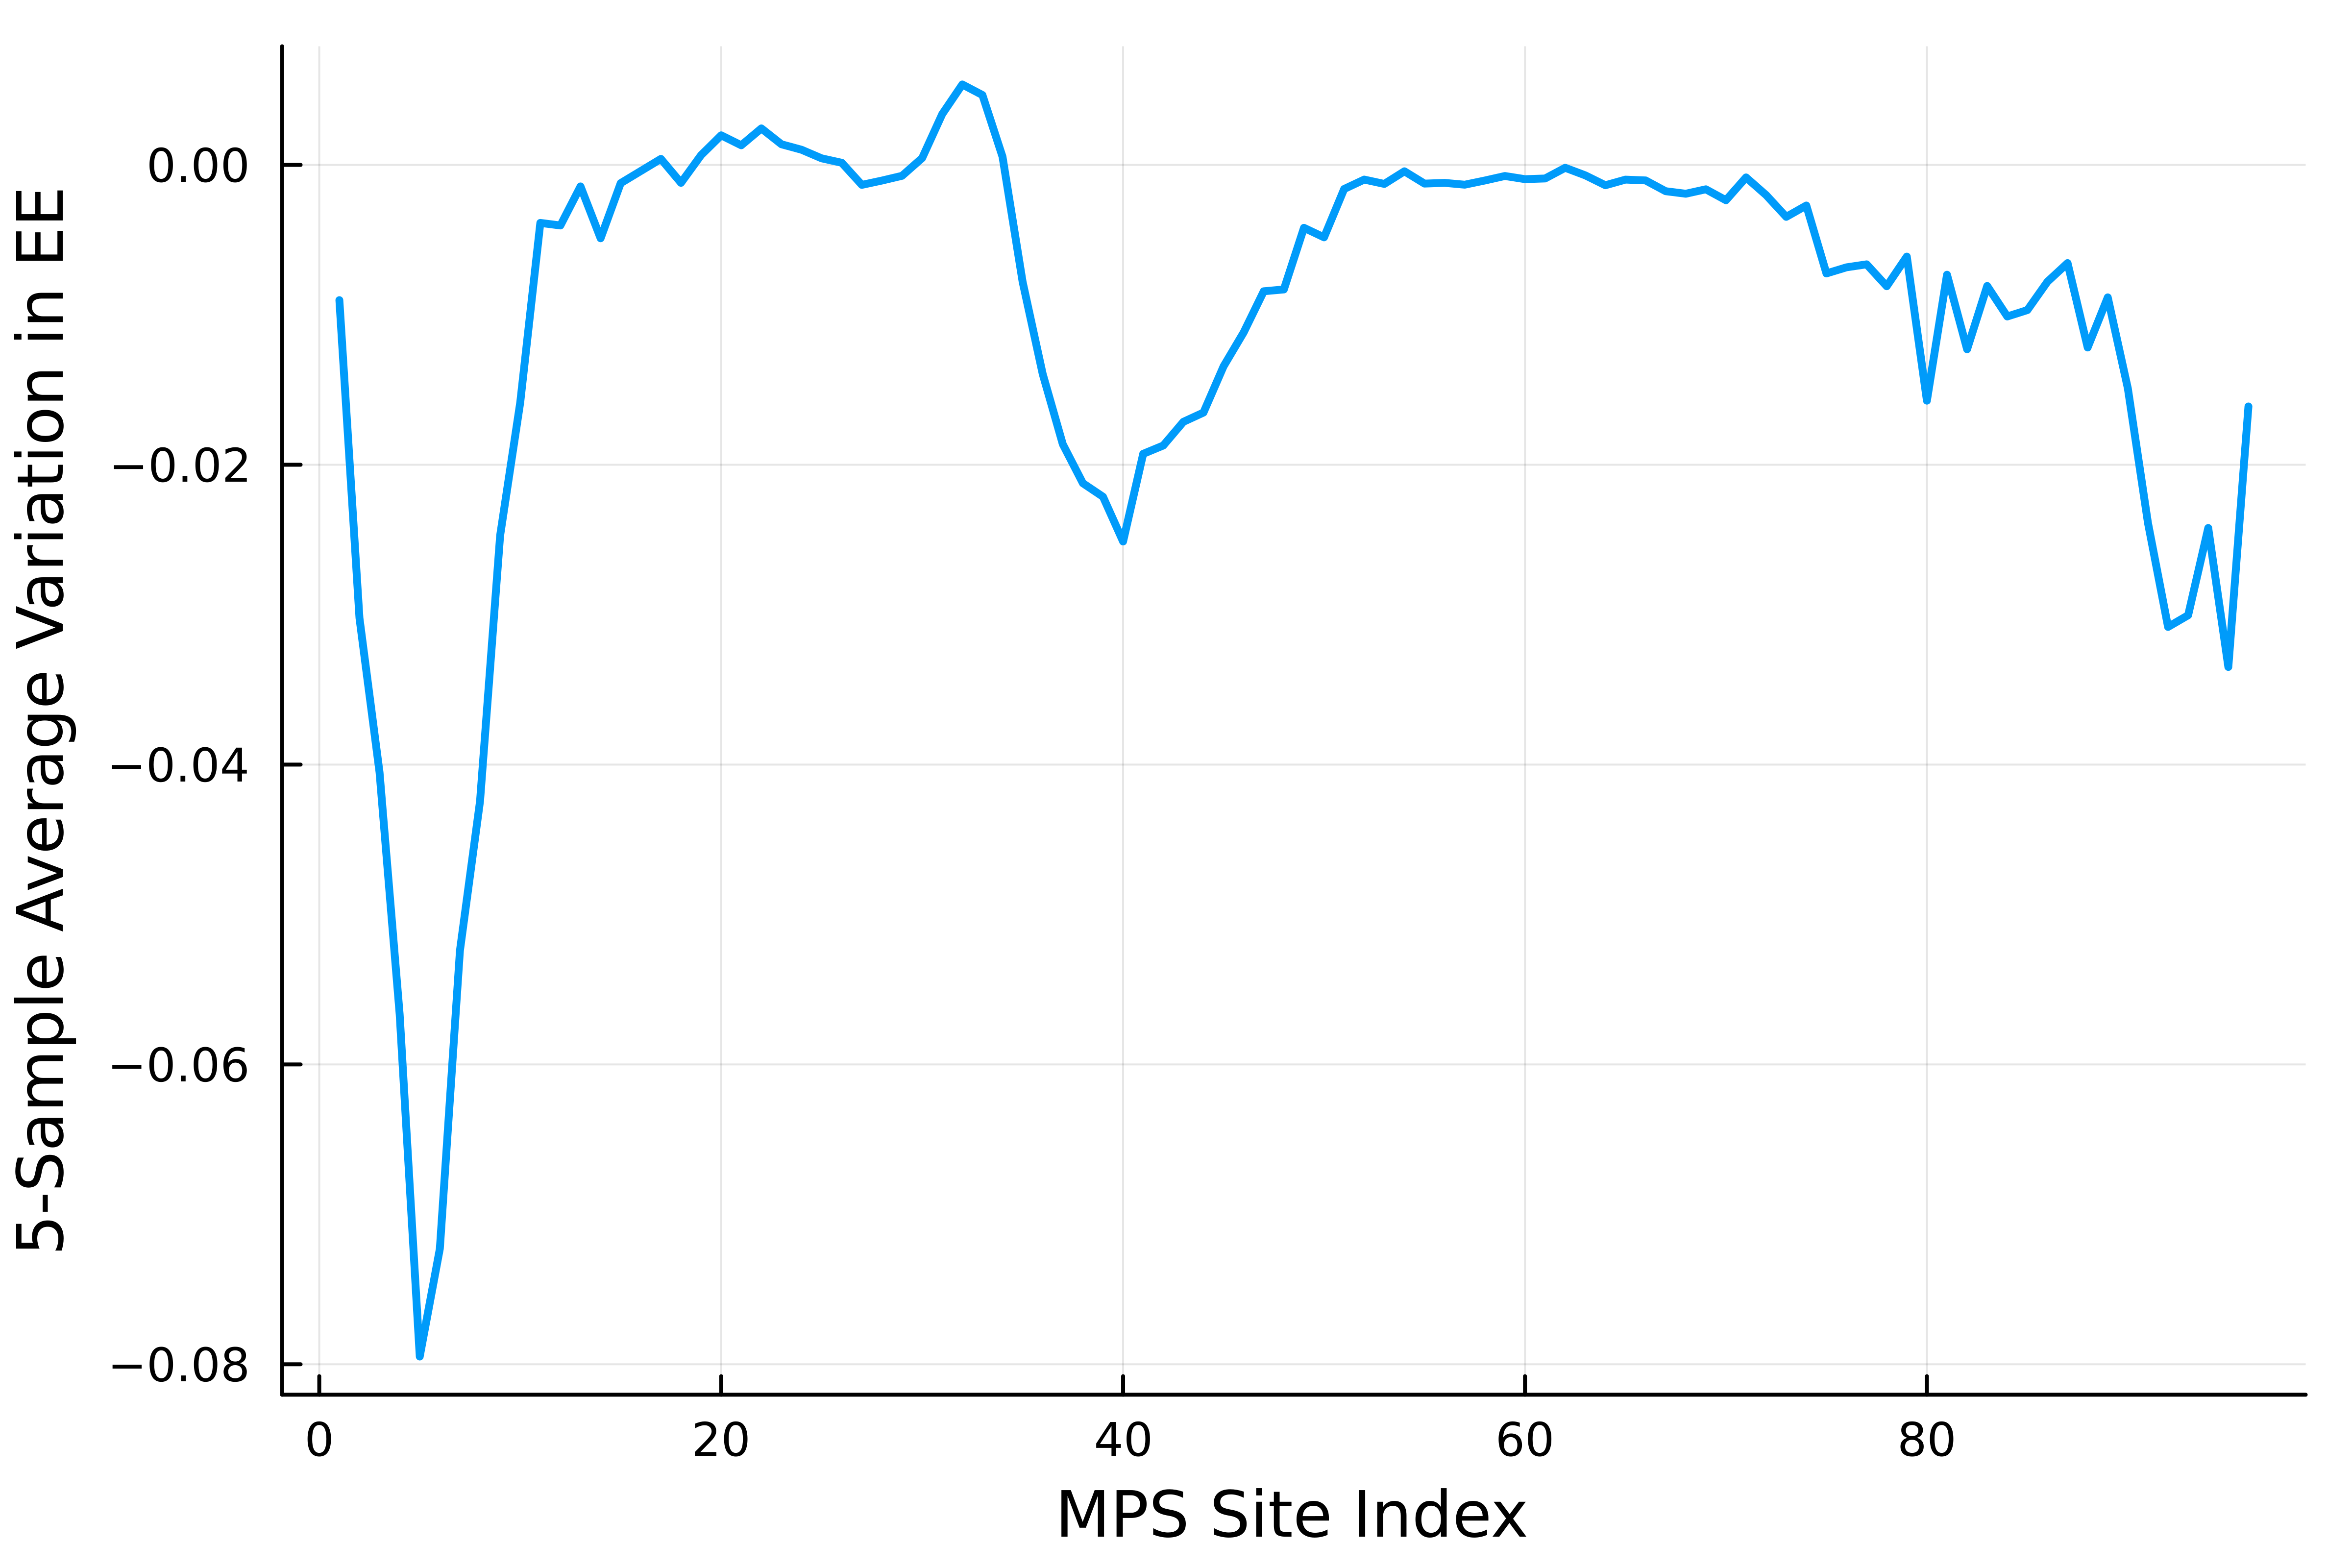

In [45]:
plot(mean(per_sample_average_δs), label="", lw=2, dpi=800)
xlabel!("MPS Site Index")
ylabel!("5-Sample Average Variation in EE")
#savefig("figs_attempt2/5_sample_av_variation_state_0.png")

All of Class 0

In [17]:
per_sample_average_δs = []
for sample_id in class_0_idxs
    println("Computing EE for sample $sample_id")
    sample_average_δs = [ComputeAverageVariation(sample_id, site, mps_state_0) for site=1:96]
    push!(per_sample_average_δs, sample_average_δs)
end

Computing EE for sample 1


Computing EE for sample 3


Computing EE for sample 4


Computing EE for sample 7


Computing EE for sample 8

Computing EE for sample 15
Computing EE for sample 19


Computing EE for sample 20


Computing EE for sample 24


Computing EE for sample 28


Computing EE for sample 36

Computing EE for sample 44


Computing EE for sample 45


Computing EE for sample 47


Computing EE for sample 48


Computing EE for sample 50
Computing EE for sample 54


Computing EE for sample 57

Computing EE for sample 58


Computing EE for sample 62


Computing EE for sample 66


Computing EE for sample 73


Computing EE for sample 84


Computing EE for sample 85
Computing EE for sample 86


Computing EE for sample 87


Computing EE for sample 89


Computing EE for sample 91


Computing EE for sample 94


Computing EE for sample 97


Computing EE for sample 98

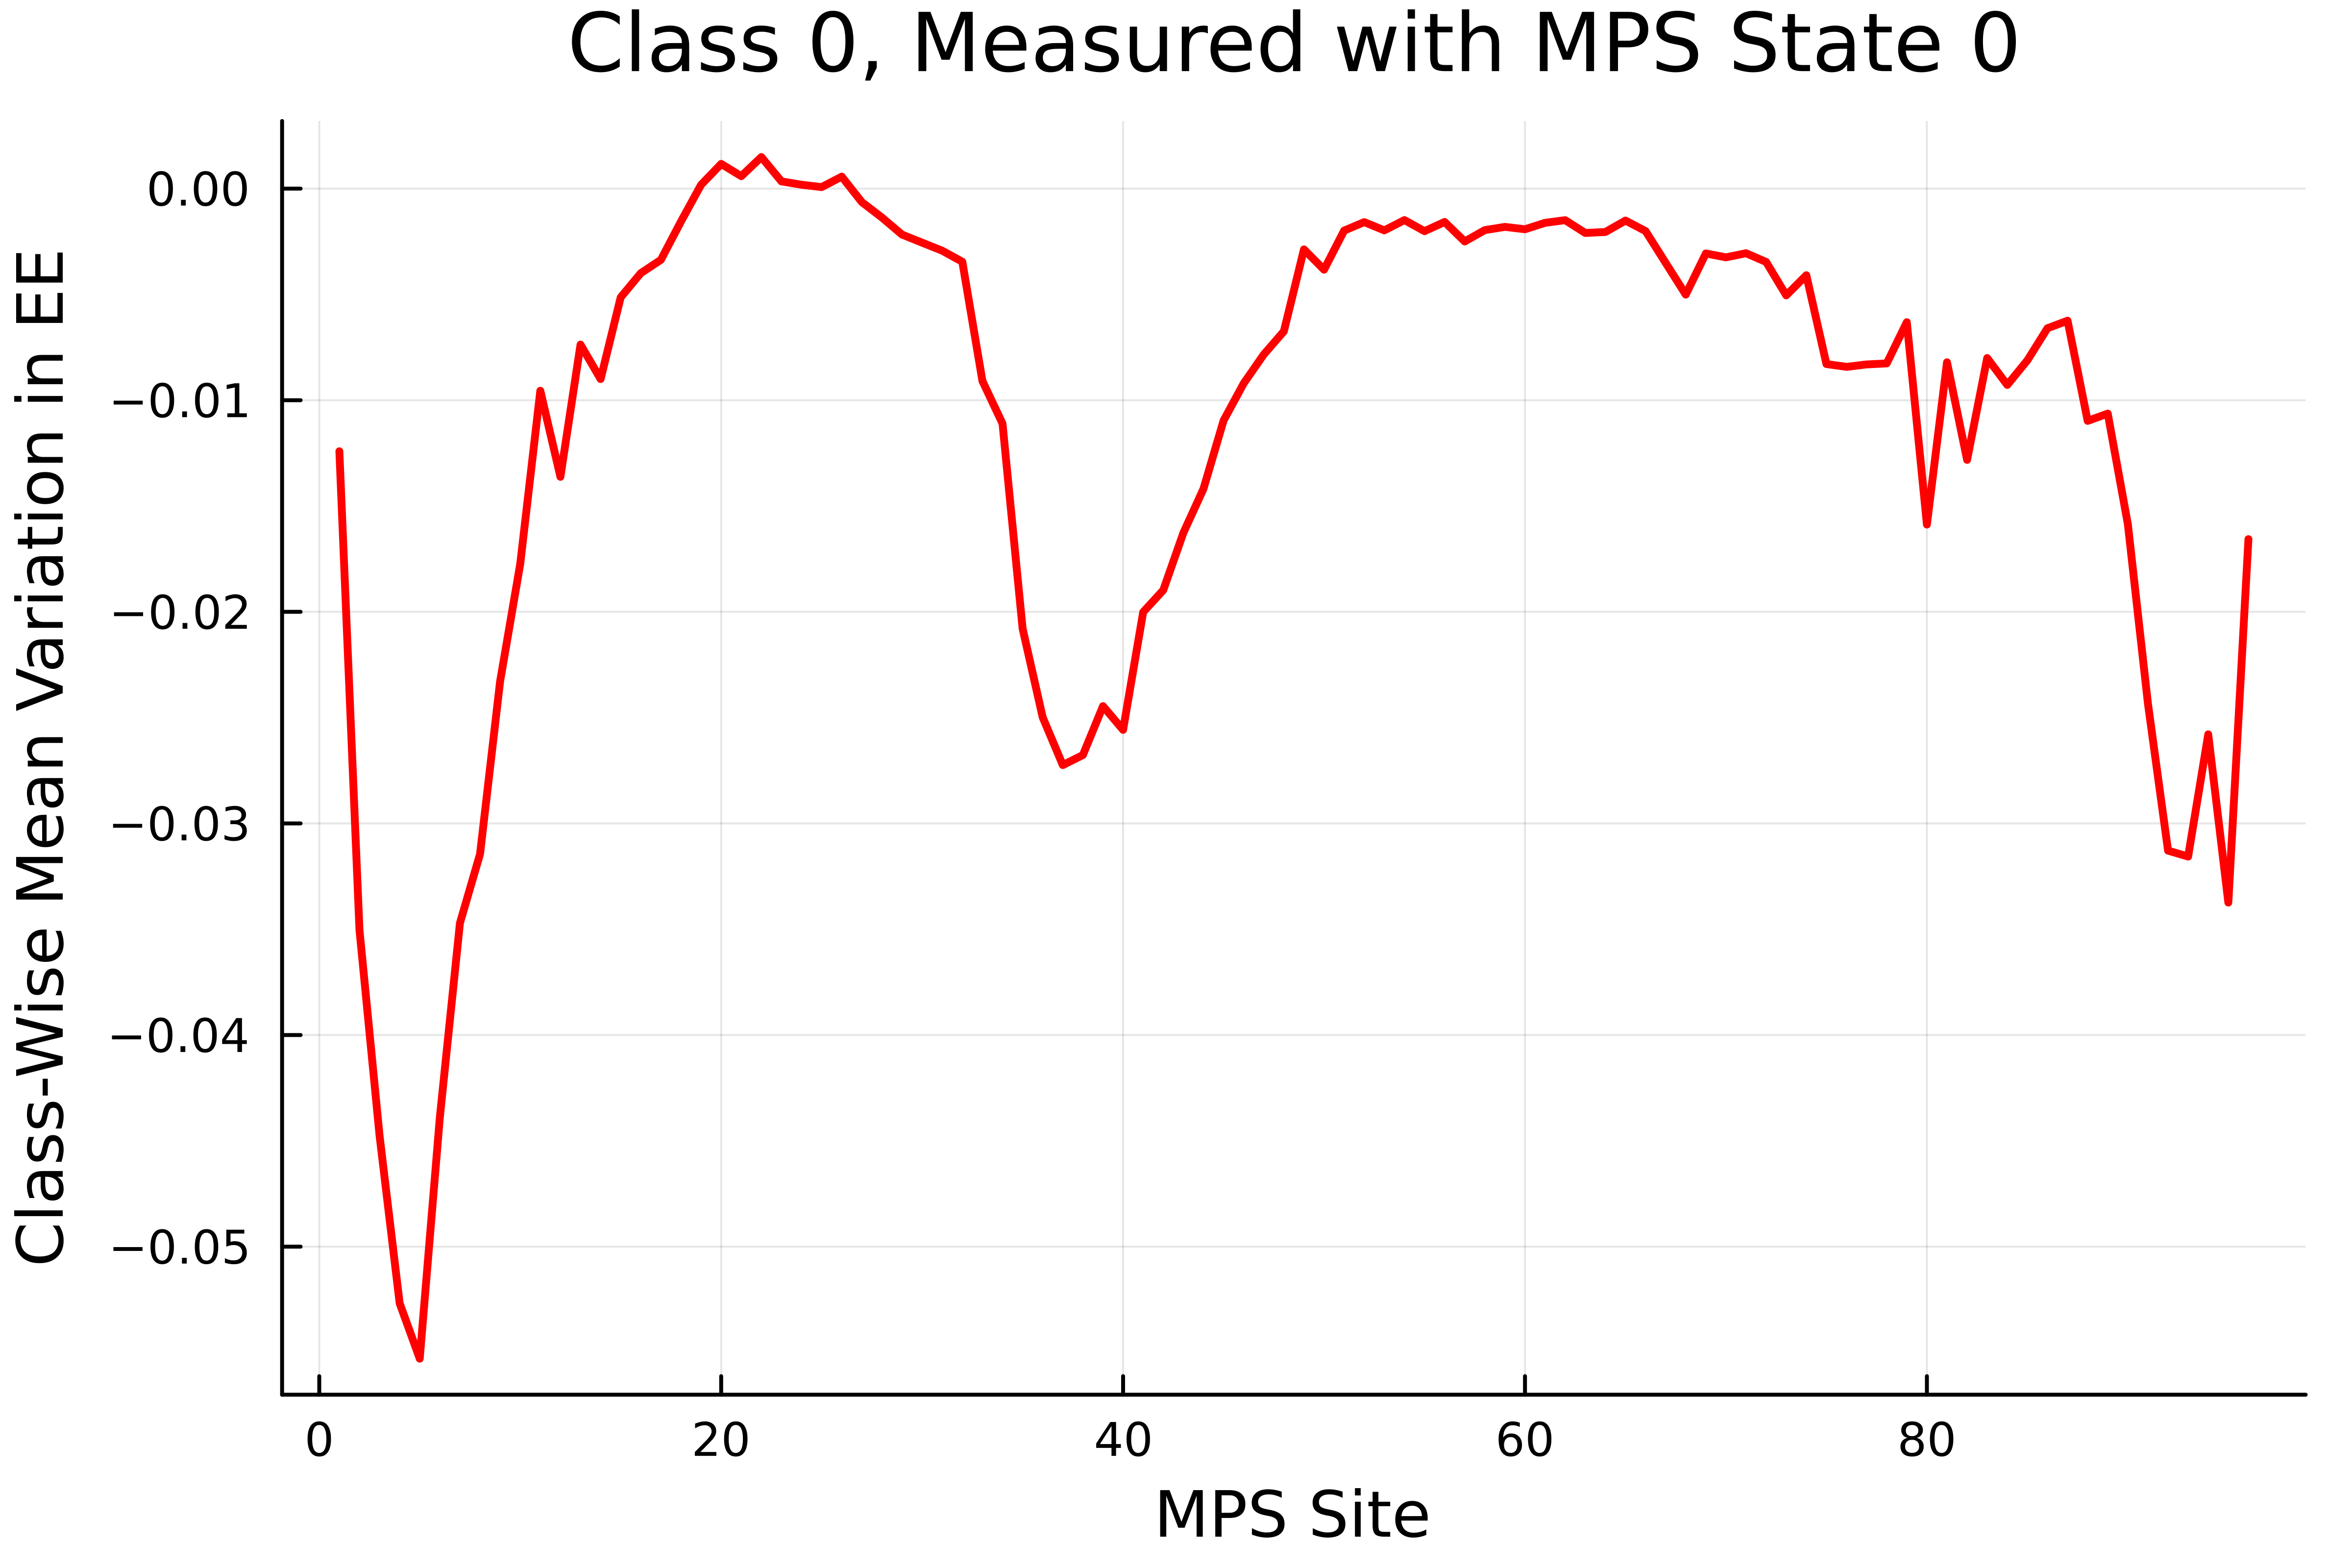

In [25]:
plot(mean(per_sample_average_δs), label="", lw=2, dpi=800, color=:red)
xlabel!("MPS Site")
ylabel!("Class-Wise Mean Variation in EE")
title!("Class 0, Measured with MPS State 0")
#savefig("figs_attempt2/class_0_variation_EE.png")

In [26]:
per_sample_average_δs = []
for sample_id in class_0_idxs
    println("Computing EE for sample $sample_id")
    sample_average_δs = [ComputeAverageVariation(sample_id, site, mps_state_1) for site=1:96]
    push!(per_sample_average_δs, sample_average_δs)
end

Computing EE for sample 1


Computing EE for sample 3


Computing EE for sample 4


Computing EE for sample 7


Computing EE for sample 8


Computing EE for sample 15


Computing EE for sample 19


Computing EE for sample 20


Computing EE for sample 24


Computing EE for sample 28

Computing EE for sample 36


Computing EE for sample 44


Computing EE for sample 45


Computing EE for sample 47
Computing EE for sample 48


Computing EE for sample 50


Computing EE for sample 54


Computing EE for sample 57


Computing EE for sample 58


Computing EE for sample 62


Computing EE for sample 66


Computing EE for sample 73

Computing EE for sample 84


Computing EE for sample 85
Computing EE for sample 86


Computing EE for sample 87


Computing EE for sample 89


Computing EE for sample 91


Computing EE for sample 94


Computing EE for sample 97


Computing EE for sample 98

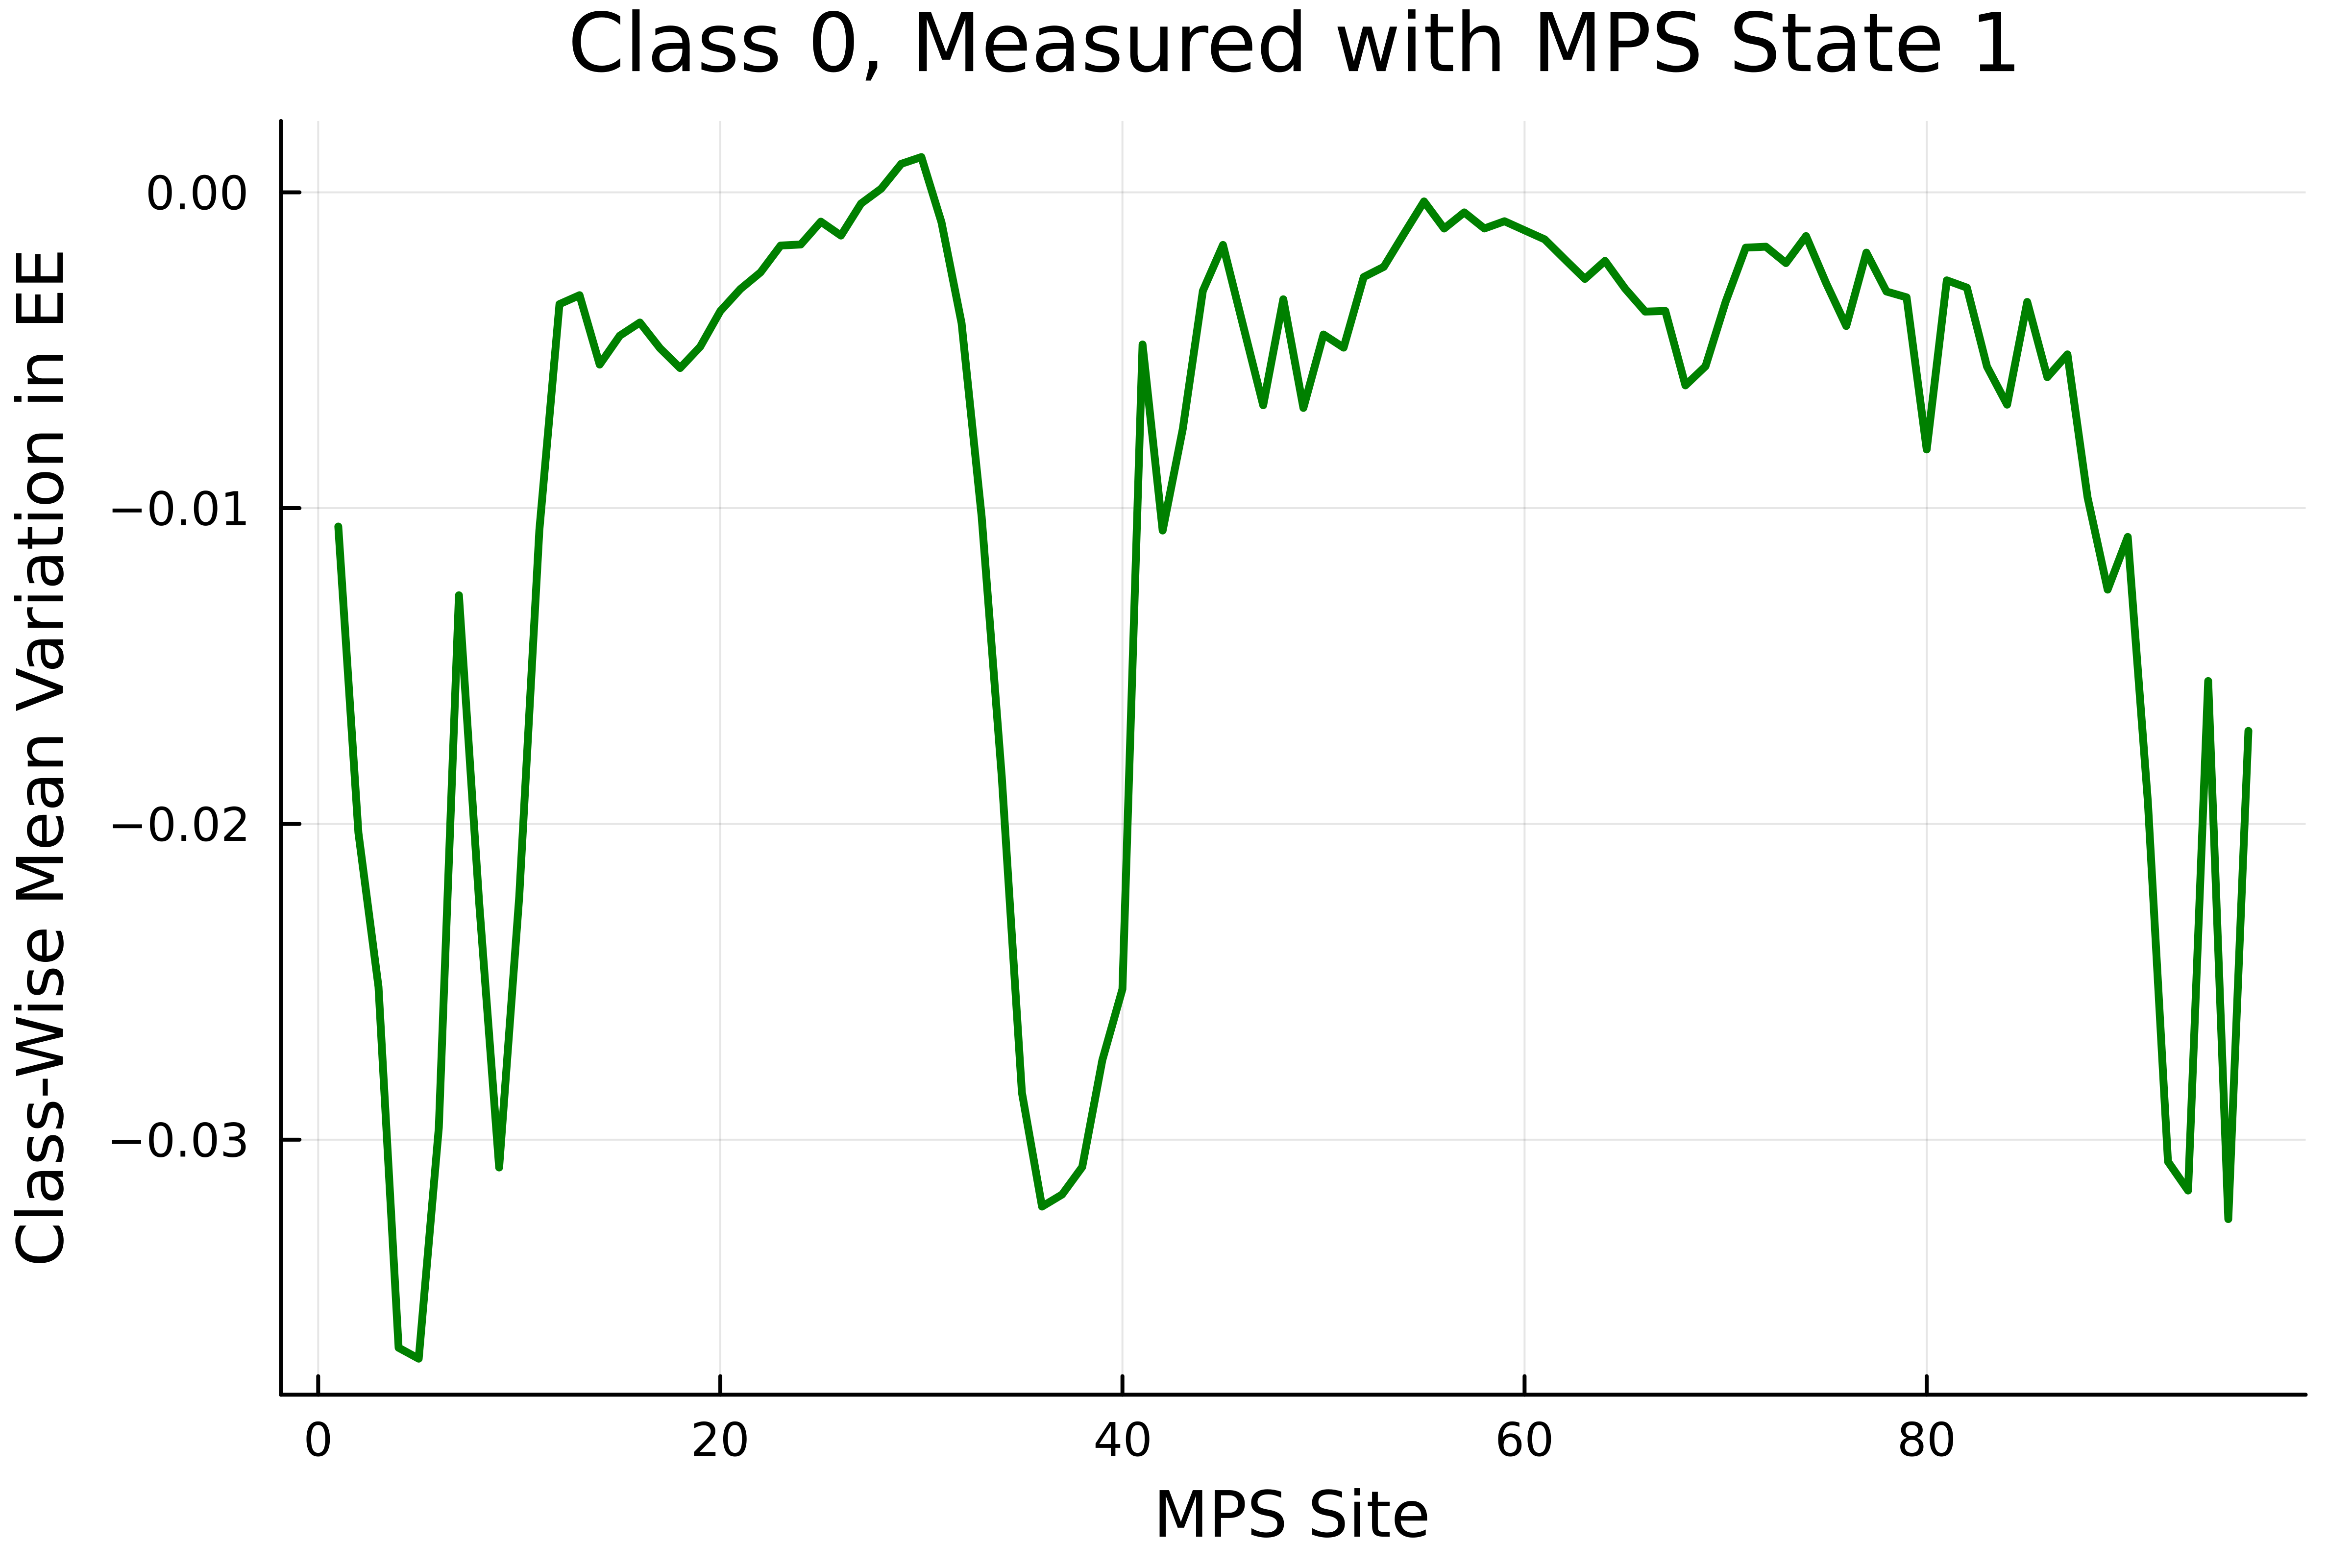

In [31]:
plot(mean(per_sample_average_δs), label="", lw=2, dpi=800, color=:green)
xlabel!("MPS Site")
ylabel!("Class-Wise Mean Variation in EE")
title!("Class 0, Measured with MPS State 1")
#savefig("figs_attempt2/class_0_variation_EE_state_1.png")